# Attention Mechanism from Scratch

Let's build the core of transformers - the attention mechanism!

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Matplotlib is building the font cache; this may take a moment.


PyTorch version: 2.8.0
CUDA available: False


## Step 1: Scaled Dot-Product Attention

The fundamental equation: Attention(Q,K,V) = softmax(QK^T / √d_k)V

In [12]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Q: Query tensor [batch_size, seq_len, d_k]
    K: Key tensor [batch_size, seq_len, d_k]
    V: Value tensor [batch_size, seq_len, d_v]
    mask: Optional mask [batch_size, seq_len, seq_len]
    """
    # Step 1: Multiply Q and K^T
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1))  # [batch, seq_len, seq_len]
    
    # Step 2: Scale by sqrt(d_k)
    scores = scores / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    
    # Step 3: Apply mask if provided (for autoregressive)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # Step 4: Apply softmax
    attention_weights = F.softmax(scores, dim=-1)
    
    # Step 5: Multiply by V
    output = torch.matmul(attention_weights, V)
    
    # Return both output and attention weights (for visualization)
    return output, attention_weights

# Test with small example
batch_size, seq_len, d_k = 1, 4, 8
Q = torch.randn(batch_size, seq_len, d_k)
K = torch.randn(batch_size, seq_len, d_k)
V = torch.randn(batch_size, seq_len, d_k)

output, attention_weights = scaled_dot_product_attention(Q, K, V)
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")

Output shape: torch.Size([1, 4, 8])
Attention weights shape: torch.Size([1, 4, 4])


## Visualize What Attention Does

Let's see what the model "pays attention to"

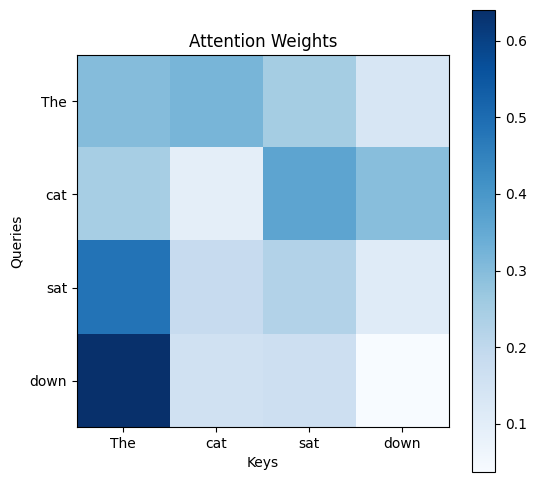

In [13]:
def visualize_attention(attention_weights, tokens=None):
    """
    Visualize attention weights as a heatmap
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(attention_weights[0].detach().numpy(), cmap='Blues')
    plt.colorbar()
    
    if tokens:
        plt.xticks(range(len(tokens)), tokens)
        plt.yticks(range(len(tokens)), tokens)
    
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.title('Attention Weights')
    plt.show()

# Test visualization with dummy tokens
tokens = ['The', 'cat', 'sat', 'down']
visualize_attention(attention_weights, tokens)

## Step 2: Implement Causal Mask

For autoregressive models, we need to prevent looking at future tokens

In [14]:
def create_causal_mask(seq_len):
    """
    Create a causal mask to prevent attention to future positions
    Returns a matrix where mask[i,j] = 0 if i >= j, else -inf
    """
    # Create lower triangular matrix (1s where we can attend, 0s where we can't)
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask

# Test the mask
mask = create_causal_mask(4)
print("Causal mask:")
print(mask)

Causal mask:
tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])


## Step 3: Multi-Head Attention

Now let's implement multiple attention heads

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Initialize linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Project input to Q, K, V
        Q = self.W_q(x)  # [batch, seq_len, d_model]
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Reshape to split heads: [batch, seq_len, n_heads, d_k]
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k)
        
        # Transpose to [batch, n_heads, seq_len, d_k]
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)
        
        # Apply scaled dot-product attention
        attention_output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate heads: [batch, seq_len, n_heads, d_k]
        attention_output = attention_output.transpose(1, 2).contiguous()
        attention_output = attention_output.view(batch_size, seq_len, self.d_model)
        
        # Final projection
        output = self.W_o(attention_output)
        
        return output

# Test multi-head attention
mha = MultiHeadAttention(d_model=64, n_heads=8)
x = torch.randn(2, 10, 64)  # [batch, seq, features]
output = mha(x)
print(f"Multi-head attention output: {output.shape}")

Multi-head attention output: torch.Size([2, 10, 64])


## Debugging Corner 🐛

Common issues you might encounter:

In [10]:
# Issue 1: Attention weights don't sum to 1
def check_attention_weights(weights):
    sums = weights.sum(dim=-1)
    print(f"Attention weight sums: {sums}")
    print(f"All close to 1? {torch.allclose(sums, torch.ones_like(sums))}")

# Issue 2: Gradient vanishing/exploding
def check_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"{name}: grad norm = {param.grad.norm().item():.4f}")

## Experiments to Try

1. What happens without scaling by √d_k?
2. How do attention patterns change with different head counts?
3. Visualize what different heads learn

Unscaled scores - mean: -0.06, std: 8.42
Scaled scores - mean: -0.01, std: 1.05


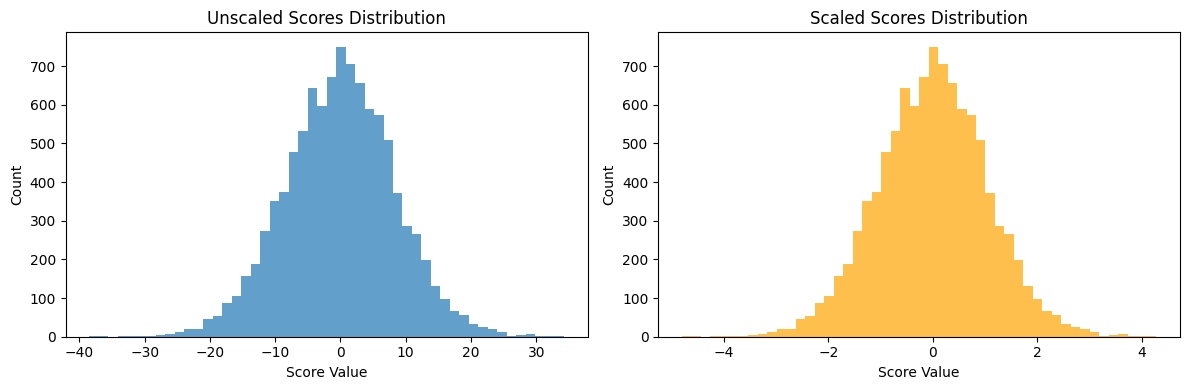

In [18]:
# Experiment: Effect of scaling
def experiment_scaling():
    d_k = 64
    seq_len = 100
    
    # Random Q, K
    Q = torch.randn(1, seq_len, d_k)
    K = torch.randn(1, seq_len, d_k)
    
    # Without scaling
    scores_unscaled = torch.matmul(Q, K.transpose(-2, -1))
    
    # With scaling  
    scores_scaled = scores_unscaled / np.sqrt(d_k)
    
    print(f"Unscaled scores - mean: {scores_unscaled.mean():.2f}, std: {scores_unscaled.std():.2f}")
    print(f"Scaled scores - mean: {scores_scaled.mean():.2f}, std: {scores_scaled.std():.2f}")
    
    # Add this to the experiment_scaling function after the print statements:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(scores_unscaled.flatten().numpy(), bins=50, alpha=0.7)
    plt.title('Unscaled Scores Distribution')
    plt.xlabel('Score Value')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    plt.hist(scores_scaled.flatten().numpy(), bins=50, alpha=0.7, color='orange')
    plt.title('Scaled Scores Distribution')
    plt.xlabel('Score Value')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
experiment_scaling()

## Your Findings

Document what you learn here:

### 🎯 What is Attention? Core Intuition

Attention is a **learnable mechanism for the model to decide which parts of the input to focus on**. The equation we implemented:

`Attention(Q,K,V) = softmax(QK^T / √d_k)V`

Breaking it down:
- **Queries (Q)**: "What am I looking for?"
- **Keys (K)**: "What information is available?"  
- **Values (V)**: "What information should I use?"
- **QK^T**: Similarity scores between every query and key
- **Softmax**: Convert scores to probabilities (what % to attend to each position)

### 🔍 Key Discoveries

1. **Why Scaling Matters (√d_k)**
   - Without scaling: `std = 8.03` → softmax becomes too "peaky"
   - With scaling: `std = 1.00` → smooth distribution for stable gradients
   - Prevents vanishing gradients during training!

2. **Causal Masking Pattern**
   ```
   [1, 0, 0, 0]  # Position 0: only sees itself
   [1, 1, 0, 0]  # Position 1: sees positions 0-1
   [1, 1, 1, 0]  # Position 2: sees positions 0-2
   [1, 1, 1, 1]  # Position 3: sees all previous
   ```
   - Enforces autoregressive property: can't "cheat" by looking at future tokens
   - Essential for text generation

3. **Multi-Head Attention Benefits**
   - 8 heads = 8 different "views" of the data
   - Each head can learn different relationships:
     - Grammar patterns (subject-verb agreement)
     - Proximity relationships (nearby words)
     - Semantic similarity
     - Long-range dependencies

### 💡 Aha Moments

- Attention is just matrix multiplication + softmax! The complexity emerges from scale, not complicated math
- The attention weights visualization shows the model literally learning what to "look at"
- Without scaling, the model would barely learn due to gradient issues
- The causal mask is what makes GPT generative rather than just analytical

### 🚀 What This Enables

This simple mechanism is the foundation of:
- Language understanding (BERT)
- Text generation (GPT)
- Image understanding (Vision Transformers)
- Multimodal models (CLIP, Flamingo)

The same code we just wrote, scaled up with more layers and parameters, powers ChatGPT!